<a href="https://colab.research.google.com/github/ziatdinovmax/OpticalNanoImagingML/blob/main/OpticalNanoSpectroscopy_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoder analysis of optical nanospectroscopy data

- Notebook prepared by Maxim Ziatdinov
- Data from Patrick El-Khoury team
- Last notebook revision on Dec 8th, 2023

The Variational Autoencoder (VAE) is based on the idea that complex real-world (in this case, experimental) observations can be explained by a small number of *latent variables*. It seeks to learn  this 'latent code', which is a probabilistic, compressed representation of input data, residing in a lower-dimensional space, from which the original data can be reconstructed.

If you look at the VAE's (simplified) architecture, it learns how to compress the original observations into a small number of latent variables using an encoder neural network and then decompress the original observations back from those latent variables via a decoder neural network. In the process of doing so, it learns the latent code - the most important information needed to describe the whole dataset, while discarding all the information it considers irrelevant (such as noise).

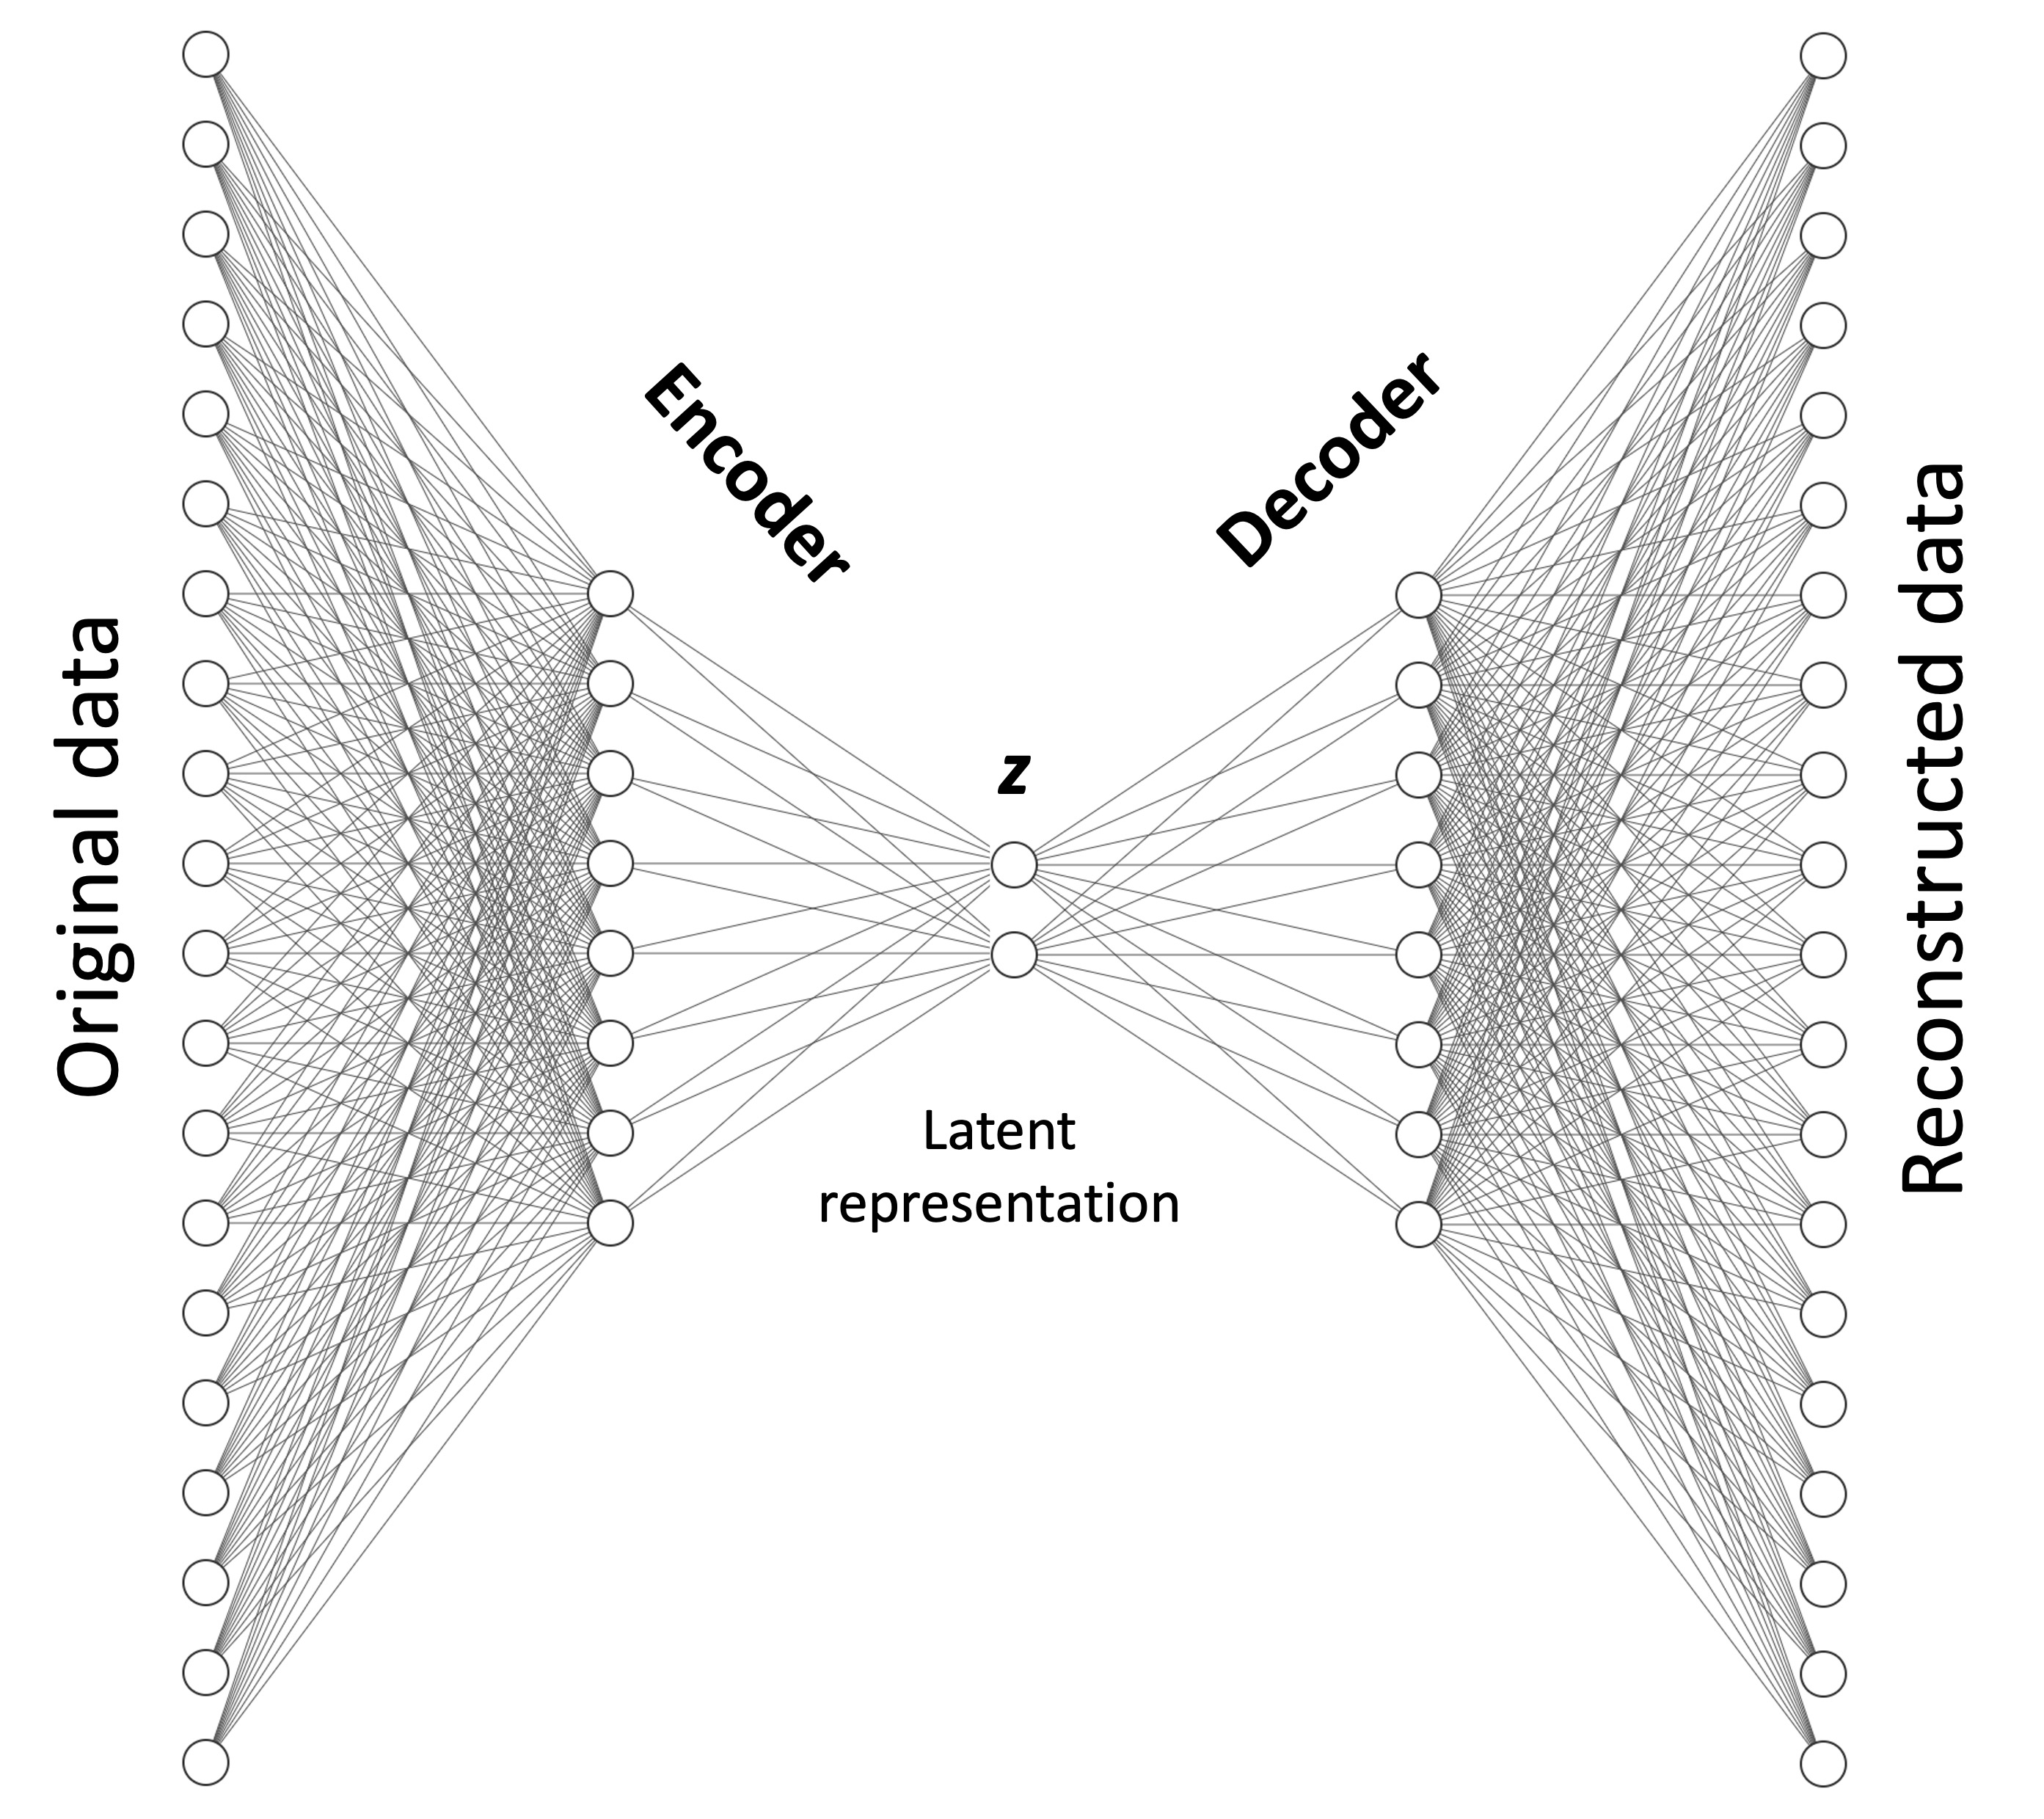


We are going to use [pyroVED](https://github.com/ziatdinovmax/pyroVED) package that I wrote a few years ago for applying VAE with various constraints and invariances towards learning physically meaningful latent representations of data.

In [ ]:
!pip install pyroved

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 677.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 8.3 MB/s eta 0:00:00


## Import libraries/pacakges

Import pyroved, pytorch, numpy, and matplotlib:

In [ ]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt
import numpy as np

## Load data

Next, we load data into the notebook. We use [NumPy's](https://en.wikipedia.org/wiki/NumPy) ```genfromtxt``` to convert a csv file into a format understandable by machine learning methods in Python.

In [ ]:
data1 = np.genfromtxt('/content/s024-nearfield-3D.csv', delimiter=',', dtype=None, encoding=None)

## Prepare data

Let's check the dimensionality ("shape") of the data:

In [ ]:
data1.shape

(2501, 1602)

Based on the accompanying .gwy files it appears that the correct data shape is 50x50x1600, where the first two dimensions are image height and width and the third one is a number of spectral bands. Because of the way it was saved, the spatial dimensions were flattened into 50x50 = 2500. There are also additional non-numerical entries asociated with saved column labels. Hence, we are going to remove those entries.

In [ ]:
hdata1 = data1[1:, 2:]

We can also "unflatten" the spatial dimension for plotting purposes:

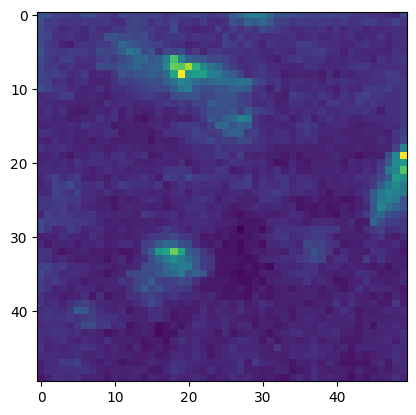

In [ ]:
band = 700
plt.imshow(hdata1.reshape(50, 50, 1600)[..., band])

Let's extract the start and end wavenumber values and convert them to energies for plotting purposes:

In [ ]:
wv_start = data1[0, 2]
wv_end = data1[0, -1]

energies = 1239.8  / np.linspace(wv_start, wv_end, hdata1.shape[1])

Let's first check for the outliers that may skew the analysis. Here we treat very large negative values as outliers. First, we identify the spectra that have them.

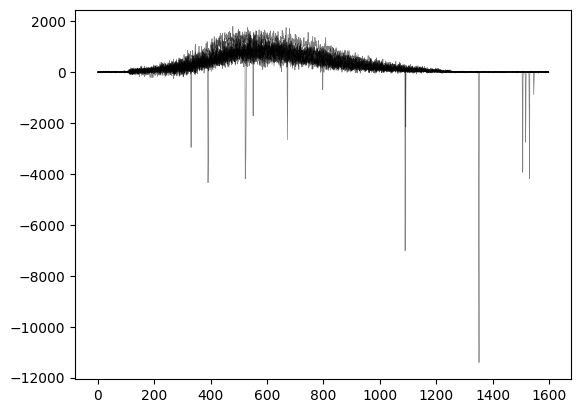

In [ ]:
outliers = hdata1 < -500

outlier_indices, _ = np.where(outliers)
outlier_indices = np.unique(outlier_indices)

for idx in outlier_indices:
    plt.plot(hdata1[idx], lw=.5, alpha=0.5, c='k')

Next, we replace those outliers with the median value of spectrum where they were detected.

In [ ]:
for idx in outlier_indices:
    # Calculate the median of the non-outlier values in this spectrum
    spectrum_median = np.median(hdata1[idx, ~outliers[idx]])

    # Replace outliers in this spectrum with the spectrum-specific median
    hdata1[idx, outliers[idx]] = spectrum_median

Plot the same spectra after the outlier removal:

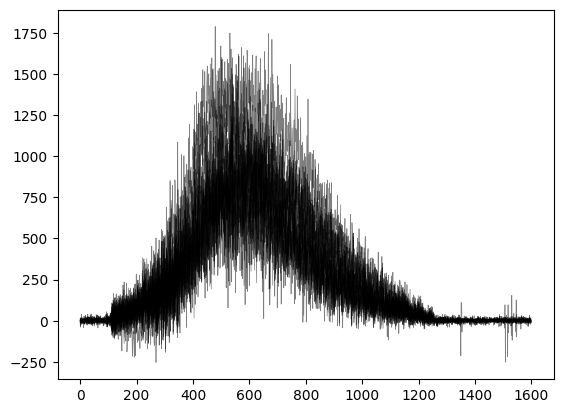

In [ ]:
for idx in outlier_indices:
    plt.plot(hdata1[idx], lw=.5, alpha=0.5, c='k')

Normalize data to [0, 1] range. This step is not required, but is highly recommended for better perfomance of ML tools.

In [ ]:
hdata1 = (hdata1 - hdata1.min()) / hdata1.ptp()

pyroVED works with [PyTorch](https://en.wikipedia.org/wiki/PyTorch) tensors - which are absically numpy arrays on GPU. We write a simple function that translates numpy arrays into torch tensors and initialize a ```train_loader``` object for training our model:

In [ ]:
def prepare_data(data):
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data).float()
    return data.unsqueeze(1)

train_loader = pv.utils.init_dataloader(prepare_data(hdata1), batch_size=64)

## VAE

Finally, let's train a VAE model. The training process is aimed at identifying a low-dimensional 'latent code' from original data. 'Latent code' is a probabilistic, compressed representation of input data, residing in a lower-dimensional space, from which the original data can be reconstructed.

In [ ]:
in_dim = (1600,)

# Initialize VAE
vae = pv.models.iVAE(in_dim, latent_dim=2)

# Use deeper NNs (this is optional)
vae.set_encoder(pv.nets.convEncoderNet(in_dim))
vae.set_decoder(pv.nets.convDecoderNet(2, in_dim))

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(200):
    trainer.step(train_loader)
    trainer.print_statistics()

/usr/local/lib/python3.10/dist-packages/pyroved/nets/conv.py:129: UserWarning: 'bilinear' mode is not supported for 1D and 3D; switching to 'nearest' mode
  warn(warn_msg, category=UserWarning)


Epoch: 1 Training loss: 559.9848
Epoch: 2 Training loss: 390.5561
Epoch: 3 Training loss: 388.9566
Epoch: 4 Training loss: 386.4454
Epoch: 5 Training loss: 385.6456
Epoch: 6 Training loss: 385.3521
Epoch: 7 Training loss: 385.3649
Epoch: 8 Training loss: 384.8767
Epoch: 9 Training loss: 384.7329
Epoch: 10 Training loss: 384.6511
Epoch: 11 Training loss: 384.4613
Epoch: 12 Training loss: 384.2359
Epoch: 13 Training loss: 384.0215
Epoch: 14 Training loss: 383.7820
Epoch: 15 Training loss: 383.8099
Epoch: 16 Training loss: 383.6934
Epoch: 17 Training loss: 383.6505
Epoch: 18 Training loss: 383.6473
Epoch: 19 Training loss: 383.7008
Epoch: 20 Training loss: 383.6325
Epoch: 21 Training loss: 383.4750
Epoch: 22 Training loss: 383.5761
Epoch: 23 Training loss: 383.5569
Epoch: 24 Training loss: 383.4524
Epoch: 25 Training loss: 383.4258
Epoch: 26 Training loss: 383.3831
Epoch: 27 Training loss: 383.3898
Epoch: 28 Training loss: 383.5118
Epoch: 29 Training loss: 383.4320
Epoch: 30 Training loss

Plot the learned latent manifold. A latent manifold refers to a continuous, structured subset of the latent space where each point can be decoded into a meaningful output via a decoder part of the trained VAE. Essentially, it's the region in the latent space that corresponds to valid or realistic outputs. The continuous nature of the manifold allows for smooth transitions between different points. When you move along the manifold in the latent space, you can observe gradual changes in the generated outputs. We have selected the [-3, 3] range for each dimension of 'z', since it covers covers over 99% of the probability mass of a standard normal distribution.

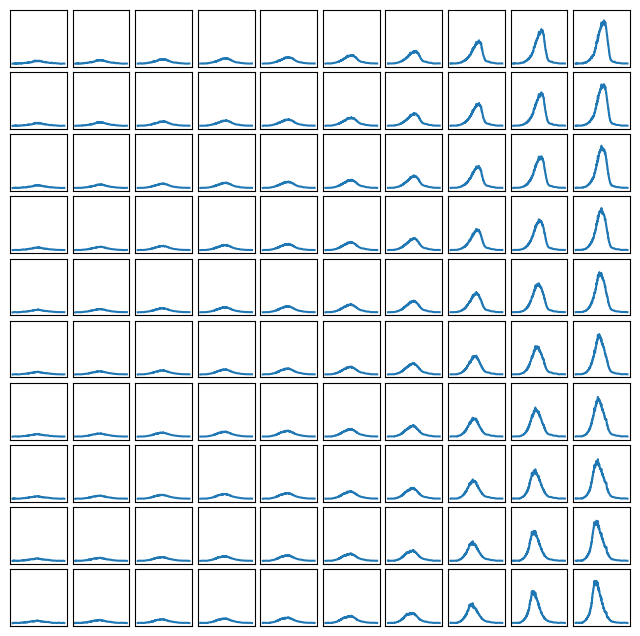

In [ ]:
d = 10  # specify grid density

# Get the latent manifold
manifold = vae.manifold2d(d, z_coord=(-3.0, 3.0, -3.0, 3.0), plot=False)

# Plot
# The manifold2d method has a built-in plotting method, but it doesn't allow passing a custom x-axis such as energies.
# Hence, we will do ploting "manually"
_, axes = plt.subplots(d, d, figsize=(8, 8),
                           subplot_kw={'xticks': [], 'yticks': []},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
ylim = [0, 0.7]
for ax, y in zip(axes.flat, manifold):
    ax.plot(energies, y.squeeze())
    ax.set_ylim(*ylim)
plt.show()

We can also "back-project" the encoded latent variables onto the original image space. Note that absolute values and sign are arbitrary, but pay attention to the relative changes in contrast and what physics maybe potentially associated with them.

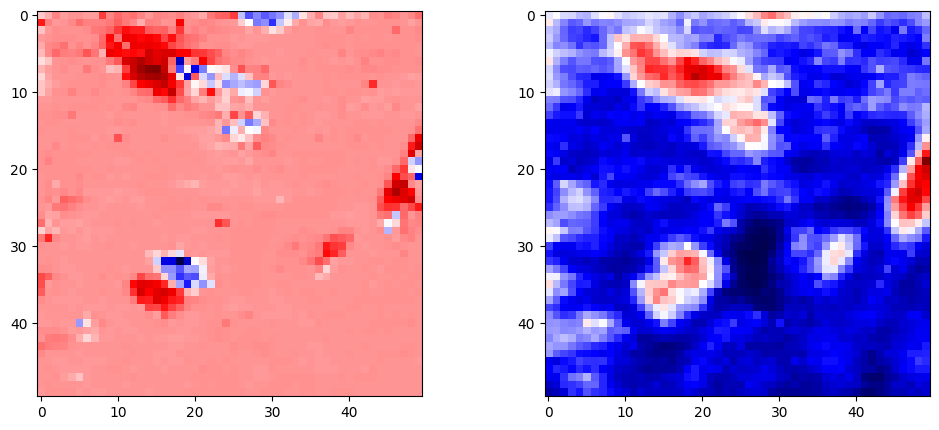

In [ ]:
z, _ = vae.encode(prepare_data(hdata1))

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(z[:, -2].reshape(50, 50), cmap='seismic')
ax2.imshow(z[:, -1].reshape(50, 50), cmap='seismic')

## Post-processing

Finally, let's extract a specific column from the latent manifold. Note that we have the flexibility to generate any number of samples from the latent code and to select the grid density in the latent space at our discretion. This capability significantly enhances the visualization and interpretation aspects of our analysis.

In [ ]:
d = 100  # specify grid density

# Get the latent manifold
manifold = vae.manifold2d(d, z_coord=(-3.0, 3.0, -3.0, 3.0), plot=False)

#Extract a spcific column
latent_profile = manifold.squeeze().reshape(d, d, 1600)[:, -1, :].numpy()

... and plot the spectra contained in it:

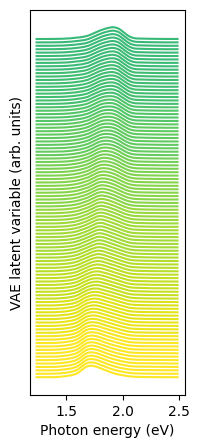

In [ ]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

shift_amount = -0.15

latent_profile_s = np.array([savgol_filter(d, window_length=200, polyorder=3) for d in latent_profile])


# More robust peak finding
peak_positions = []
for i in range(len(latent_profile_s)):
    peaks, _ = find_peaks(latent_profile_s[i], height=0.1, width=100)  # Using a height threshold for demonstration
    if peaks.size > 0:
        peak_positions.append(peaks[np.argmax(latent_profile_s[i][peaks])])  # Get the highest peak
    else:
        peak_positions.append(0)  # Default to 0 if no peak is found

# Normalize the robust peak positions
normalized_peak_positions = np.array(peak_positions) / np.max(peak_positions)


# Choose a color map
cmap = plt.cm.viridis

plt.figure(figsize=(2, 5))

# Plotting with gradient colors
for i in range(len(latent_profile_s)):
    color = cmap(normalized_peak_positions[i])  # Get color from the color map
    plt.plot(energies, latent_profile_s[i] + i * shift_amount, color=color)

plt.yticks([])

# Customizing the plot
plt.xlabel('Photon energy (eV)')
plt.ylabel('VAE latent variable (arb. units)')

# Display the plot
plt.show()

Plot the histogram of the peak positions:

Text(0, 0.5, 'Count')

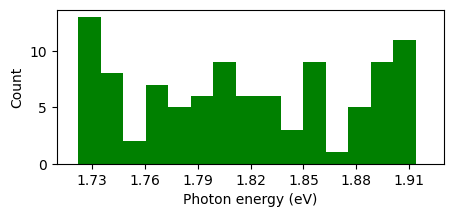

In [ ]:
plt.figure(figsize=(5, 2))
plt.hist(energies[peak_positions], bins=15, color='green');
plt.xlim(1.71, 1.93)
plt.xticks(np.arange(1.73, 1.92, 0.03));
plt.xlabel("Photon energy (eV)")
plt.ylabel("Count")